In [3]:
import numpy as np
import pandas as pd

df_heart = pd.read_csv('./dataset/heart.csv')
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# 输出分类值，及各个类别数目
df_heart.target.value_counts()

target
1    165
0    138
Name: count, dtype: int64

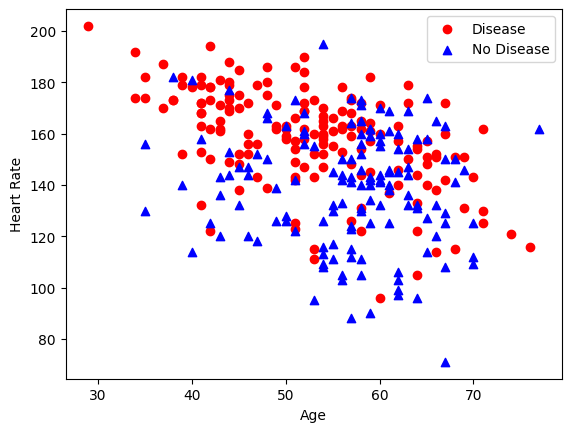

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=df_heart.age[df_heart.target == 1],
            y=df_heart.thalach[(df_heart.target == 1)], c='red')
plt.scatter(x=df_heart.age[df_heart.target == 0],
            y=df_heart.thalach[(df_heart.target == 0)], marker='^', c='blue')
plt.legend(["Disease", "No Disease"])
plt.xlabel("Age")
plt.ylabel("Heart Rate")
plt.show()

In [6]:
# 把3个文本型变量转换为哑变量
a = pd.get_dummies(df_heart['cp'], prefix='cp')
b = pd.get_dummies(df_heart['thal'], prefix='thal')
c = pd.get_dummies(df_heart['slope'], prefix='slope')
# 把哑变量添加进dataframe
frames = [df_heart, a, b, c]
df_heart = pd.concat(frames, axis=1)
df_heart = df_heart.drop(columns=['cp', 'thal', 'slope'])
df_heart.head()  # 显示新的dataframe

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,False,False,True,False,True,False,False,True,False,False
1,37,1,130,250,0,1,187,0,3.5,0,...,False,True,False,False,False,True,False,True,False,False
2,41,0,130,204,0,0,172,0,1.4,0,...,True,False,False,False,False,True,False,False,False,True
3,56,1,120,236,0,1,178,0,0.8,0,...,True,False,False,False,False,True,False,False,False,True
4,57,0,120,354,0,1,163,1,0.6,0,...,False,False,False,False,False,True,False,False,False,True


In [7]:
# 构建特征集
X = df_heart.drop(['target'], axis=1)
y = df_heart.target.values
y = y.reshape(-1, 1)  # -1是相对索引，等价于len(y)
print("张量X的形状：", X.shape)
print("张量y的形状：", y.shape)

张量X的形状： (303, 21)
张量y的形状： (303, 1)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 首先定义一个Sigmoid函数，输入Z，返回y'
def sigmoid(z):
    y_hat = 1 / (1 + np.exp(-z))
    return y_hat

In [11]:
# 然后定义损失函数
def loss_function(X, y, w, b):
    y_hat = sigmoid(np.dot(X, w) + b)
    loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    cost = np.sum(loss) / X.shape[0]
    return cost

In [12]:
# 然后构建梯度下降的函数
def gradient_descent(X, y, w, b, alpha, iterations):
    l_history = np.zeros(iterations)
    w_history = np.zeros((iterations, w.shape[0], w.shape[1]))
    b_history = np.zeros(iterations)
    for i in range(iterations):
        y_hat = sigmoid(np.dot(X, w) + b)
        loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        derivative_w = np.dot(X.T, ((y_hat - y))) / X.shape[0]
        derivative_b = np.sum(y_hat - y) / X.shape[0]
        w = w - alpha * derivative_w
        b = b - alpha * derivative_b
        l_history[i] = loss_function(X, y, w, b)
        print("轮次", i + 1, "当前轮训练集损失：", l_history[i])
        w_history[i] = w  # 梯度下降过程中权重的历史 请注意w_history和w的形状
        b_history[i] = b  # 梯度下降过程中偏置的历史
    return l_history, w_history, b_history

In [13]:
def predict(X, w, b):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    y_pred = np.zeros((y_hat.shape[0], 1))
    for i in range(y_hat.shape[0]):
        if y_hat[i, 0] < 0.5:
            y_pred[i, 0] = 0
        else:
            y_pred[i, 0] = 1
    return y_pred

In [14]:
def logistic_regression(X, y, w, b, lr, iter):  # 定义逻辑回归模型
    l_history, w_history, b_history = gradient_descent(X, y, w, b, lr, iter)  #梯度下降
    print("训练最终损失:", l_history[-1])  # 打印最终损失
    y_pred = predict(X, w_history[-1], b_history[-1])  # 进行预测
    traning_acc = 100 - np.mean(np.abs(y_pred - y_train)) * 100  # 计算准确率
    print("逻辑回归训练准确率: {:.2f}%".format(traning_acc))  # 打印准确率
    return l_history, w_history, b_history  # 返回训练历史记录

In [15]:
#初始化参数
dimension = X.shape[1]  # 这里的维度 len(X)是矩阵的行的数，维度是列的数目
weight = np.full((dimension, 1), 0.1)  # 权重向量，向量一般是1D，但这里实际上创建了2D张量
bias = 0  # 偏置值
#初始化超参数
alpha = 1  # 学习速率
iterations = 500  # 迭代次数

In [16]:
# 用逻辑回归函数训练机器
loss_history, weight_history, bias_history = \
    logistic_regression(X_train, y_train, weight, bias, alpha, iterations)

轮次 1 当前轮训练集损失： 0.6180267038074496
轮次 2 当前轮训练集损失： 0.5617180720913116
轮次 3 当前轮训练集损失： 0.5236206199183228
轮次 4 当前轮训练集损失： 0.4968435362799337
轮次 5 当前轮训练集损失： 0.4773915362013217
轮次 6 当前轮训练集损失： 0.46283007526164693
轮次 7 当前轮训练集损失： 0.45163633264634945
轮次 8 当前轮训练集损失： 0.44282832408121353
轮次 9 当前轮训练集损失： 0.4357534857690524
轮次 10 当前轮训练集损失： 0.4299659145982706
轮次 11 当前轮训练集损失： 0.4251531734471754
轮次 12 当前轮训练集损失： 0.4210913894283136
轮次 13 当前轮训练集损失： 0.4176169312547128
轮次 14 当前轮训练集损失： 0.41460807102247255
轮次 15 当前轮训练集损失： 0.41197282108706795
轮次 16 当前轮训练集损失： 0.40964068712289475
轮次 17 当前轮训练集损失： 0.4075569633190925
轮次 18 当前轮训练集损失： 0.405678713558823
轮次 19 当前轮训练集损失： 0.4039718930116841
轮次 20 当前轮训练集损失： 0.40240925517094867
轮次 21 当前轮训练集损失： 0.40096880889377423
轮次 22 当前轮训练集损失： 0.39963266648270157
轮次 23 当前轮训练集损失： 0.3983861737082285
轮次 24 当前轮训练集损失： 0.39721724574968875
轮次 25 当前轮训练集损失： 0.3961158553319605
轮次 26 当前轮训练集损失： 0.3950736345972836
轮次 27 当前轮训练集损失： 0.3940835628430313
轮次 28 当前轮训练集损失： 0.39313971970293016
轮次 29 当前轮训练集损失： 0.3

In [17]:
y_pred = predict(X_test, weight_history[-1], bias_history[-1])  # 预测测试集
testing_acc = 100 - np.mean(np.abs(y_pred - y_test)) * 100  # 计算准确率
print("逻辑回归测试准确率: {:.2f}%".format(testing_acc))

逻辑回归测试准确率: 88.52%


In [18]:
print("逻辑回归预测分类值:", predict(X_test, weight_history[-1], bias_history[-1]))

逻辑回归预测分类值: [[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


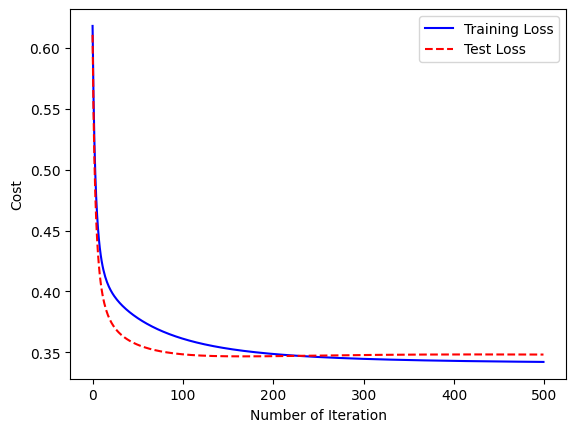

In [19]:
loss_history_test = np.zeros(iterations)  # 初始化历史损失
for i in range(iterations):  #求训练过程中不同参数带来的测试集损失
    loss_history_test[i] = loss_function(X_test, y_test,
                                         weight_history[i], bias_history[i])
index = np.arange(0, iterations, 1)
plt.plot(index, loss_history, c='blue', linestyle='solid')
plt.plot(index, loss_history_test, c='red', linestyle='dashed')
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.show()  # 同时显示显示训练集和测试集损失曲线

In [20]:
# 直接调用sklearn
from sklearn.linear_model import LogisticRegression  #导入逻辑回归模型

lr = LogisticRegression()  # lr,就代表是逻辑回归模型
lr.fit(X_train, y_train)  # fit,就相当于是梯度下降
print("SK-learn逻辑回归测试准确率{:.2f}%".format(lr.score(X_test, y_test) * 100))

SK-learn逻辑回归测试准确率85.25%


/Users/cag2050/Documents/PycharmProjects/zero_basic_machine_learning/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
